# Adult Income

In [46]:
import pandas as pd
import numpy as np

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_classification

# walidation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r"compiletime version 3.5 of module '_catboost' does not match runtime version 3.6")

    import catboost as ctb

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import matplotlib.pyplot as plt
import seaborn as sns

import helper as h 

%matplotlib inline

In [47]:
%time train = pd.read_hdf('../input/train.adult.h5')

CPU times: user 41.7 ms, sys: 4.25 ms, total: 46 ms
Wall time: 44.7 ms


## scanning information, cleaning data (missing, not-numeric, constants?) checking correlations, visualization

In [48]:
train.keys()

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Martial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target'],
      dtype='object')

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [50]:
train.sample(5)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
27718,42,Private,303388,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,65,United-States,<=50K
31131,17,Private,277541,11th,7,Never-married,Sales,Own-child,White,True,0,0,5,United-States,<=50K
19826,21,Private,82497,Some-college,10,Never-married,Other-service,Not-in-family,White,False,0,0,30,United-States,<=50K
16552,25,Private,295108,HS-grad,9,Never-married,Handlers-cleaners,Unmarried,Black,False,0,0,25,United-States,<=50K
16737,41,Private,185267,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,True,0,0,40,United-States,<=50K


In [51]:
def check_missing():
    for column in train.columns:
        missing = column, train[column].isnull().sum()
        
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('Workclass', 1836)
('Occupation', 1843)
('Country', 583)


In [52]:
train = train.fillna(-1)

In [53]:
check_missing()

In [54]:
def if_constants():
    constants = []
    for column in train.columns:
        if train[column].nunique() == 1:
            constants.append(column)
    return constants
if_constants()

[]

In [55]:
train.Target.unique()

array(['<=50K', '>50K'], dtype=object)

In [56]:
train['Target_Cat'] = (train['Target'] != '<=50K').astype('int8')

In [57]:
train.sample()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Target_Cat
27497,76,Self-emp-not-inc,117169,7th-8th,4,Never-married,Farming-fishing,Not-in-family,White,True,0,0,30,United-States,<=50K,0


In [58]:
cat_feats = train.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    train['{0}_Cat'.format(cat_feat)] = pd.factorize( train[cat_feat] )[0]

In [59]:
train.sample()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,...,Country,Target,Target_Cat,Workclass_Cat,Education_Cat,Martial Status_Cat,Occupation_Cat,Relationship_Cat,Race_Cat,Country_Cat
22828,33,Private,153588,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,True,...,United-States,<=50K,0,2,1,1,9,1,0,0


In [60]:
feats = train.select_dtypes(include=[np.int]).columns
feats

Index(['fnlwgt', 'Education-Num', 'Target_Cat', 'Workclass_Cat',
       'Education_Cat', 'Martial Status_Cat', 'Occupation_Cat',
       'Relationship_Cat', 'Race_Cat', 'Country_Cat'],
      dtype='object')

In [61]:
feats = [feat for feat in feats if feat != 'Target_Cat' and feat != 'fnlwgt']
feats

['Education-Num',
 'Workclass_Cat',
 'Education_Cat',
 'Martial Status_Cat',
 'Occupation_Cat',
 'Relationship_Cat',
 'Race_Cat',
 'Country_Cat']

## first check - no extra features (two models, ROC, learning curve, feature importance)

### model - LogisticRegression, kFold, accuracy_score

In [62]:
X = train[ feats ].values
y = train[ 'Target_Cat' ].values

cv = KFold(n_splits=4, random_state=2018, shuffle=True)
model = LogisticRegression()

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = accuracy_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.7698473948258987, 0.0010552069288888948)


### learning curve

In [63]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

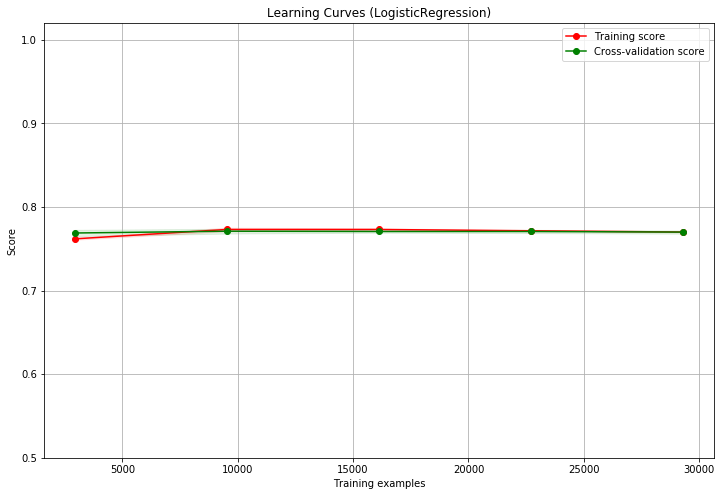

In [64]:
plt = plot_learning_curve(LogisticRegression(), "Learning Curves (LogisticRegression)", X, y, ylim=(0.5, 1.02), cv=10)
plt.show()

### model - LogisticRegression, kFold, recall_score

In [65]:
X = train[ feats ].values
y = train[ 'Target_Cat' ].values

cv = KFold(n_splits=4, random_state=2018, shuffle=True)
model = LogisticRegression()

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = recall_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.22386385696732042, 0.006578540258886957)


### model - RandomForest, kFold, accuracy_score

In [66]:
X = train[ feats ].values
y = train[ 'Target_Cat' ].values

cv = KFold(n_splits=4, random_state=2018, shuffle=True)
model = RandomForestClassifier(max_depth=5, n_estimators =5, max_features=3)

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = accuracy_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.8200607452434624, 0.002868446594333722)


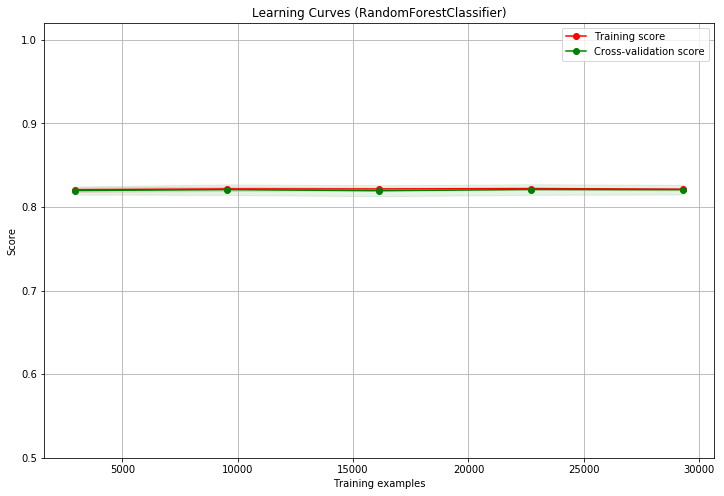

In [67]:
plt = plot_learning_curve(RandomForestClassifier(max_depth=5, n_estimators =5, max_features=3), "Learning Curves (RandomForestClassifier)", X, y, ylim=(0.5, 1.02), cv=10)
plt.show()

In [68]:
def draw_feature_importances(model, feats):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importance")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ feats[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

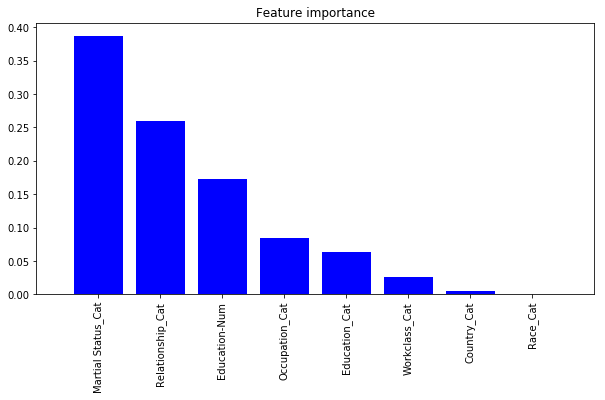

In [69]:
draw_feature_importances(model, feats)

### model - RandomForest, kFold, recall_score

In [70]:
def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = recall_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.4200896260928564, 0.005206019319590467)


In [71]:
train.corr()

,Age,fnlwgt,Education-Num,Sex,Capital Gain,Capital Loss,Hours per week,Target_Cat,Workclass_Cat,Education_Cat,Martial Status_Cat,Occupation_Cat,Relationship_Cat,Race_Cat,Country_Cat
Age,1.000000,-0.076646,0.036527,0.088832,0.064301,0.057775,0.068756,0.234037,0.082380,0.007767,0.424606,0.017201,-0.217767,-0.040000,-0.011572
fnlwgt,-0.076646,1.000000,-0.043195,0.026858,-0.007000,-0.010252,-0.018768,-0.009463,-0.006314,0.024188,-0.023527,0.007892,0.017142,0.000500,0.035910
Education-Num,0.036527,-0.043195,1.000000,0.012280,0.062300,0.079923,0.148123,0.335154,0.011343,-0.279614,-0.065996,-0.242997,-0.141075,-0.039760,-0.066044
Sex,0.088832,0.026858,0.012280,1.000000,0.028219,0.045567,0.229309,0.215980,-0.019347,-0.000550,-0.181870,0.147779,-0.273414,-0.067840,-0.005977
Capital Gain,0.064301,-0.007000,0.062300,0.028219,1.000000,-0.027282,0.031964,0.154853,0.002884,-0.022521,0.012773,-0.020194,-0.033732,-0.016541,-0.005300
Capital Loss,0.057775,-0.010252,0.079923,0.045567,-0.027282,1.000000,0.054256,0.150526,0.012510,-0.003192,0.006833,-0.023963,-0.050498,-0.017190,-0.004373
Hours per week,0.068756,-0.018768,0.148123,0.229309,0.031964,0.054256,1.000000,0.229689,-0.028084,-0.050025,-0.000277,-0.045240,-0.184873,-0.033115,-0.009662
Target_Cat,0.234037,-0.009463,0.335154,0.215980,0.154853,0.150526,0.229689,1.000000,0.047203,-0.046218,0.002644,-0.104691,-0.171294,-0.067713,-0.028478
Workclass_Cat,0.082380,-0.006314,0.011343,-0.019347,0.002884,0.012510,-0.028084,0.047203,1.000000,0.011666,0.035949,0.217072,0.015524,0.009359,-0.010246
Education_Cat,0.007767,0.024188,-0.279614,-0.000550,-0.022521,-0.003192,-0.050025,-0.046218,0.011666,1.000000,0.008507,0.074961,0.044319,0.029638,0.067619


### feature engineering

In [72]:
def white_husband(row):
    if row['Race'] == 'White' and row['Relationship'] == 'Husband':
        return 1
    else:
        return 0

def no_pay_no_education(row):
    if row['Workclass'] == 'Without-pay' and row['Education'] == 'Preschool':
        return 0
    else:
        return 1    
    
def capital_working_hours(row):
    if row['Capital Gain'] > 1000 and row['Hours per week'] > 35:
        return 2
    elif row['Capital Gain'] > 0 and row['Hours per week'] > 30:
        return 1
    else:
        return 0    
 
def feature_engineering(train):
    train['Race_Rel'] = train [ ['Race', 'Relationship'] ].apply(white_husband, axis=1)
    train['Workclass_Education'] = train[ ['Workclass', 'Education'] ].apply(no_pay_no_education, axis=1)
    train['Capital_Hours'] = train[ ['Capital Gain', 'Hours per week'] ].apply(capital_working_hours, axis=1)
   
    return train

In [73]:
train_fe = feature_engineering(train)

In [74]:
train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 26 columns):
Age                    32561 non-null int8
Workclass              32561 non-null object
fnlwgt                 32561 non-null int64
Education              32561 non-null object
Education-Num          32561 non-null int64
Martial Status         32561 non-null object
Occupation             32561 non-null object
Relationship           32561 non-null object
Race                   32561 non-null object
Sex                    32561 non-null bool
Capital Gain           32561 non-null int16
Capital Loss           32561 non-null int16
Hours per week         32561 non-null int8
Country                32561 non-null object
Target                 32561 non-null object
Target_Cat             32561 non-null int64
Workclass_Cat          32561 non-null int64
Education_Cat          32561 non-null int64
Martial Status_Cat     32561 non-null int64
Occupation_Cat         32561 non-null int64
Relati

In [75]:
for feat in train_fe.select_dtypes(include=[np.object]).columns:
    train_fe['{0}_Cat'.format(feat)] = pd.factorize( train[feat] )[0]

In [76]:
train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 26 columns):
Age                    32561 non-null int8
Workclass              32561 non-null object
fnlwgt                 32561 non-null int64
Education              32561 non-null object
Education-Num          32561 non-null int64
Martial Status         32561 non-null object
Occupation             32561 non-null object
Relationship           32561 non-null object
Race                   32561 non-null object
Sex                    32561 non-null bool
Capital Gain           32561 non-null int16
Capital Loss           32561 non-null int16
Hours per week         32561 non-null int8
Country                32561 non-null object
Target                 32561 non-null object
Target_Cat             32561 non-null int64
Workclass_Cat          32561 non-null int64
Education_Cat          32561 non-null int64
Martial Status_Cat     32561 non-null int64
Occupation_Cat         32561 non-null int64
Relati

In [77]:
feats = train_fe.select_dtypes(include=[np.int]).columns.values
feats = [feat for feat in feats if feat != 'Target_Cat' and feat !='fnlwgt']
feats

['Education-Num',
 'Workclass_Cat',
 'Education_Cat',
 'Martial Status_Cat',
 'Occupation_Cat',
 'Relationship_Cat',
 'Race_Cat',
 'Country_Cat',
 'Race_Rel',
 'Workclass_Education',
 'Capital_Hours']

### model - LogisticRegression, kFold, accuracy_score + feature engineering

In [78]:
X = train[ feats ].values
y = train[ 'Target_Cat' ].values

cv = KFold(n_splits=4, random_state=2018, shuffle=True)
model = LogisticRegression()

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = accuracy_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.821934115302559, 0.004581126630812648)


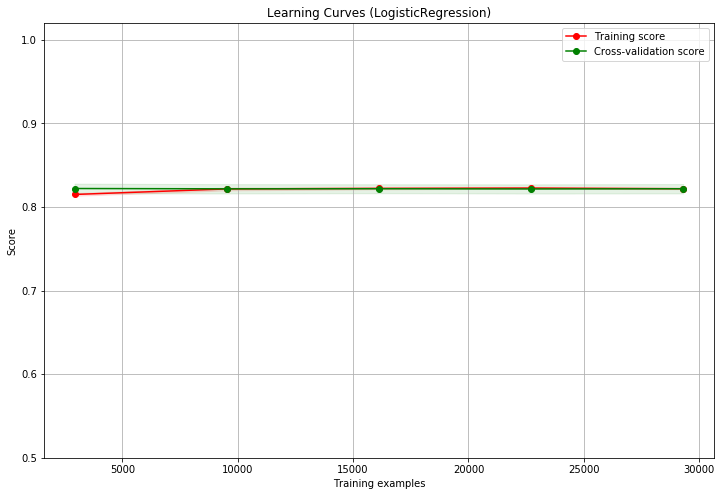

In [79]:
plt = plot_learning_curve(LogisticRegression(), "Learning Curves (LogisticRegression)", X, y, ylim=(0.5, 1.02), cv=10)
plt.show()

### model - LogisticRegression, kFold, recall_score + feature engineering

In [80]:
def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = recall_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.4585599384791346, 0.010996532663401807)


### model - LogisticRegression, kFold, precision_score + feature engineering

In [81]:
def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = precision_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.6984332762748255, 0.011926129693886909)


### model - RandomForest, kFold, accuracy_score + feature engineering

In [82]:
model = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=8)

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = accuracy_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.833543108607597, 0.00307465807920733)


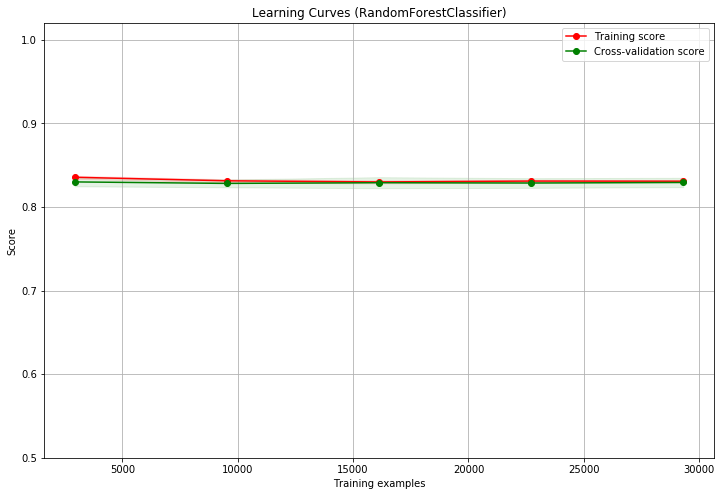

In [83]:
plt = plot_learning_curve(RandomForestClassifier(max_depth=5, n_estimators=5, max_features=8), "Learning Curves (RandomForestClassifier)", X, y, ylim=(0.5, 1.02), cv=10)
plt.show()

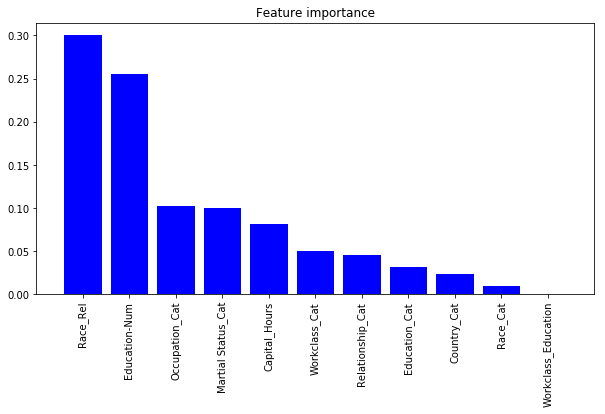

In [84]:
draw_feature_importances(model, feats)

### model - RandomForest, kFold, recall_score + feature engineering

In [85]:
model = RandomForestClassifier(max_depth=5, n_estimators=5, max_features=8)

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = recall_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.49221270331326894, 0.007064710297271166)


### model - RandomForest, kFold, precision_score + feature engineering

In [86]:
model = RandomForestClassifier(max_depth=5, n_estimators =5, max_features=8)

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = precision_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

(0.7170268465862036, 0.004639572460065448)


### model - XGBClassifier, StratifiedFold, accuracy_score + feature engineering

In [87]:
model = xgb.XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.1)

def score():
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = accuracy_score(y[test_idx], y_pred )
        scores.append(score)
    return (np.mean(scores), np.std(scores))

print(score())

/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.8357850705335658, 0.003435874807342396)


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-error:0.189107	validation_1-error:0.192114
[1]	validation_0-error:0.184234	validation_1-error:0.18806
[2]	validation_0-error:0.184889	validation_1-error:0.18806
[3]	validation_0-error:0.184889	validation_1-error:0.18806
[4]	validation_0-error:0.180016	validation_1-error:0.184007
[5]	validation_0-error:0.180016	validation_1-error:0.184007
[6]	validation_0-error:0.180016	validation_1-error:0.184007
[7]	validation_0-error:0.179975	validation_1-error:0.184007
[8]	validation_0-error:0.179975	validation_1-error:0.184007
[9]	validation_0-error:0.17973	validation_1-error:0.184253
[10]	validation_0-error:0.179812	validation_1-error:0.184007
[11]	validation_0-error:0.180098	validation_1-error:0.187569
[12]	validation_0-error:0.175225	validation_1-error:0.182533
[13]	validation_0-error:0.175676	validation_1-error:0.184621
[14]	validation_0-error:0.175348	validation_1-error:0.184498
[15]	validation_0-error:0.175348	validation_1-error:0.184498
[16]	validation_0-error:0.174898	valid

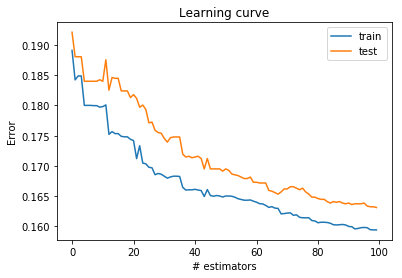

[0]	validation_0-error:0.190533	validation_1-error:0.187838
[1]	validation_0-error:0.179067	validation_1-error:0.178993
[2]	validation_0-error:0.185496	validation_1-error:0.183415
[3]	validation_0-error:0.179272	validation_1-error:0.178256
[4]	validation_0-error:0.184759	validation_1-error:0.182555
[5]	validation_0-error:0.180992	validation_1-error:0.179975
[6]	validation_0-error:0.181237	validation_1-error:0.179975
[7]	validation_0-error:0.180623	validation_1-error:0.178256
[8]	validation_0-error:0.181729	validation_1-error:0.179361
[9]	validation_0-error:0.180296	validation_1-error:0.17801
[10]	validation_0-error:0.182671	validation_1-error:0.180835
[11]	validation_0-error:0.182302	validation_1-error:0.17973
[12]	validation_0-error:0.183162	validation_1-error:0.181327
[13]	validation_0-error:0.182753	validation_1-error:0.179975
[14]	validation_0-error:0.179231	validation_1-error:0.177518
[15]	validation_0-error:0.179231	validation_1-error:0.177641
[16]	validation_0-error:0.177102	val

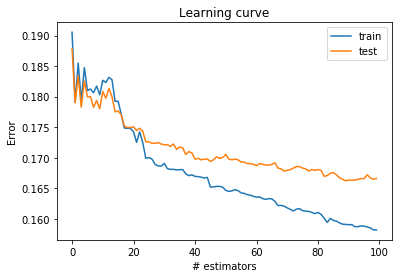

[0]	validation_0-error:0.190041	validation_1-error:0.189312
[1]	validation_0-error:0.179436	validation_1-error:0.177396
[2]	validation_0-error:0.186233	validation_1-error:0.184029
[3]	validation_0-error:0.179436	validation_1-error:0.177396
[4]	validation_0-error:0.18177	validation_1-error:0.17887
[5]	validation_0-error:0.179763	validation_1-error:0.178133
[6]	validation_0-error:0.182097	validation_1-error:0.179607
[7]	validation_0-error:0.182015	validation_1-error:0.17973
[8]	validation_0-error:0.181852	validation_1-error:0.179361
[9]	validation_0-error:0.18177	validation_1-error:0.179361
[10]	validation_0-error:0.18177	validation_1-error:0.179361
[11]	validation_0-error:0.18177	validation_1-error:0.179361
[12]	validation_0-error:0.18177	validation_1-error:0.179361
[13]	validation_0-error:0.181729	validation_1-error:0.179361
[14]	validation_0-error:0.17788	validation_1-error:0.174939
[15]	validation_0-error:0.176856	validation_1-error:0.174079
[16]	validation_0-error:0.176365	validatio

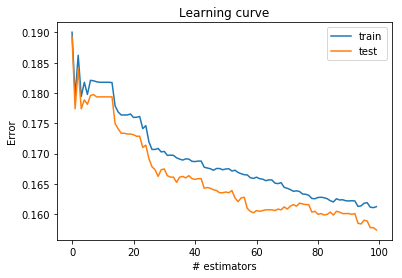

[0]	validation_0-error:0.183694	validation_1-error:0.184767
[1]	validation_0-error:0.182957	validation_1-error:0.183907
[2]	validation_0-error:0.178617	validation_1-error:0.180221
[3]	validation_0-error:0.178617	validation_1-error:0.180221
[4]	validation_0-error:0.178453	validation_1-error:0.179853
[5]	validation_0-error:0.178535	validation_1-error:0.179853
[6]	validation_0-error:0.178453	validation_1-error:0.179853
[7]	validation_0-error:0.178453	validation_1-error:0.179853
[8]	validation_0-error:0.180418	validation_1-error:0.181941
[9]	validation_0-error:0.1796	validation_1-error:0.181081
[10]	validation_0-error:0.179518	validation_1-error:0.181081
[11]	validation_0-error:0.180132	validation_1-error:0.181204
[12]	validation_0-error:0.180132	validation_1-error:0.181204
[13]	validation_0-error:0.177429	validation_1-error:0.17629
[14]	validation_0-error:0.17661	validation_1-error:0.17543
[15]	validation_0-error:0.175791	validation_1-error:0.174816
[16]	validation_0-error:0.175791	valida

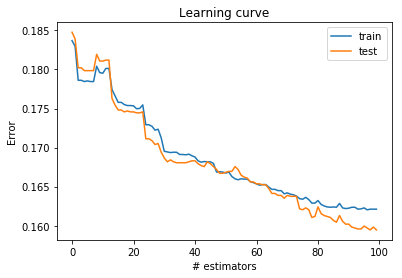

In [90]:
cv = StratifiedKFold(n_splits=4, random_state=2018)

for train_idx, test_idx in cv.split(X, y):
    model = xgb.XGBClassifier(n_estimators=100)
    
    eval_set = [
        (X[train_idx], y[train_idx]), 
        (X[test_idx],  y[test_idx]) 
    ]
    
    model.fit(X[train_idx], y[train_idx], eval_metric="error", eval_set=eval_set, verbose=True)    
    
    evals_result = model.evals_result()
    print(evals_result)
    print("")
   
    plt.title("Learning curve")
    plt.xlabel("# estimators")
    plt.ylabel("Error")
    plt.plot( model.evals_result_['validation_0']['error'], label='train' )
    plt.plot( model.evals_result_['validation_1']['error'], label='test' )
    plt.legend(loc='best')
    plt.show()

In [89]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100
    }
    
    cv = KFold(n_splits=4, random_state=2018, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(X):
        model = xgb.XGBClassifier(**xgb_params)
                
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
        y_pred[y_pred < 0] = 0

        score = accuracy_score(y[test_idx], y_pred)
        scores.append(score)
    
    print('SCORE', np.mean(scores), xgb_params)
    return{'loss': np.mean(scores), 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8386105403624751 {'max_depth': 11, 'colsample_bytree': 0.94111795271863, 'learning_rate': 0.11448409314890705, 'subsample': 0.7800165580561367, 'seed': 550, 'min_child_weight': 9, 'reg_alpha': 1.5174332105109611, 'reg_lambda': 0.7166823640800536, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8383034188279244 {'max_depth': 10, 'colsample_bytree': 0.9552574339309767, 'learning_rate': 0.11012194136118862, 'subsample': 0.7717269386721538, 'seed': 50, 'min_child_weight': 10, 'reg_alpha': 1.5116209963185574, 'reg_lambda': 0.7101707953801186, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8374434604228241 {'max_depth': 5, 'colsample_bytree': 0.9988928260950907, 'learning_rate': 0.05238128178386959, 'subsample': 0.7195935907315459, 'seed': 1300, 'min_child_weight': 10, 'reg_alpha': 1.008264115457851, 'reg_lambda': 0.7053174343725996, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8363992834220693 {'max_depth': 20, 'colsample_bytree': 0.8076153765762613, 'learning_rate': 0.05179738582253955, 'subsample': 0.9887483630871278, 'seed': 9900, 'min_child_weight': 1, 'reg_alpha': 1.0276683665702862, 'reg_lambda': 0.9631729640788598, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8364607348915174 {'max_depth': 20, 'colsample_bytree': 0.8102613676457141, 'learning_rate': 0.19361164343401388, 'subsample': 0.9932491358086682, 'seed': 7850, 'min_child_weight': 1, 'reg_alpha': 2.7118521063896264, 'reg_lambda': 0.9931247487739224, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8367985123681598 {'max_depth': 20, 'colsample_bytree': 0.811787977874919, 'learning_rate': 0.05115378343836079, 'subsample': 0.9935928253760493, 'seed': 9950, 'min_child_weight': 1, 'reg_alpha': 1.0087953427455962, 'reg_lambda': 0.9886977424736635, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8367985651842058 {'max_depth': 16, 'colsample_bytree': 0.864149031305882, 'learning_rate': 0.1881406175178037, 'subsample': 0.9031811567887659, 'seed': 5600, 'min_child_weight': 4, 'reg_alpha': 2.2496366452642107, 'reg_lambda': 0.8733774952103914, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.837105679173607 {'max_depth': 16, 'colsample_bytree': 0.8622358207803242, 'learning_rate': 0.07781579040354529, 'subsample': 0.9029630812659815, 'seed': 9400, 'min_child_weight': 4, 'reg_alpha': 1.2477542246426343, 'reg_lambda': 0.8854920699203691, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8369828630039291 {'max_depth': 16, 'colsample_bytree': 0.8573633870277528, 'learning_rate': 0.15124683228276367, 'subsample': 0.9105613146393042, 'seed': 3700, 'min_child_weight': 7, 'reg_alpha': 1.8986513738647715, 'reg_lambda': 0.9368533065639332, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8390098598503586 {'max_depth': 6, 'colsample_bytree': 0.9081939092965279, 'learning_rate': 0.08324336073331892, 'subsample': 0.9991647796625648, 'seed': 6850, 'min_child_weight': 3, 'reg_alpha': 1.216743326588039, 'reg_lambda': 0.8063369054732408, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8367371401227807 {'max_depth': 18, 'colsample_bytree': 0.8215088276976861, 'learning_rate': 0.1511535276177056, 'subsample': 0.8505237795728915, 'seed': 3400, 'min_child_weight': 7, 'reg_alpha': 1.2178669464197043, 'reg_lambda': 0.7928674490139758, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8386412981640841 {'max_depth': 8, 'colsample_bytree': 0.997545726141869, 'learning_rate': 0.08029254441761441, 'subsample': 0.9397893285175047, 'seed': 8200, 'min_child_weight': 2, 'reg_alpha': 1.7965751839042952, 'reg_lambda': 0.9400329834827454, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8374127856178587 {'max_depth': 14, 'colsample_bytree': 0.8980550027790276, 'learning_rate': 0.1427964968441916, 'subsample': 0.8358187745172386, 'seed': 5400, 'min_child_weight': 6, 'reg_alpha': 2.3560285464647337, 'reg_lambda': 0.8017344057122017, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8367985651842058 {'max_depth': 13, 'colsample_bytree': 0.8358753544199525, 'learning_rate': 0.0501550835884297, 'subsample': 0.9563593253556476, 'seed': 9950, 'min_child_weight': 5, 'reg_alpha': 1.0847137595125296, 'reg_lambda': 0.9388475502079854, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.834679442063363 {'max_depth': 19, 'colsample_bytree': 0.9040387442608679, 'learning_rate': 0.17658712291478856, 'subsample': 0.8497694018004582, 'seed': 3500, 'min_child_weight': 2, 'reg_alpha': 1.408676364018335, 'reg_lambda': 0.7546356739655622, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8365528687110803 {'max_depth': 18, 'colsample_bytree': 0.9680140869933817, 'learning_rate': 0.17664511621450038, 'subsample': 0.7022562446533094, 'seed': 2150, 'min_child_weight': 8, 'reg_alpha': 1.3866521170465953, 'reg_lambda': 0.7553393343826783, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8375663030005248 {'max_depth': 11, 'colsample_bytree': 0.9062485315466701, 'learning_rate': 0.16613069062225067, 'subsample': 0.8288941179732346, 'seed': 3850, 'min_child_weight': 3, 'reg_alpha': 2.1986021550904917, 'reg_lambda': 0.7522407914116183, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8348329858540521 {'max_depth': 19, 'colsample_bytree': 0.8884736495212097, 'learning_rate': 0.13229509642056536, 'subsample': 0.8682436308138359, 'seed': 2500, 'min_child_weight': 2, 'reg_alpha': 1.1254989281338914, 'reg_lambda': 0.8373584909962843, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8352014947242806 {'max_depth': 18, 'colsample_bytree': 0.886205618324299, 'learning_rate': 0.12970836191382393, 'subsample': 0.8667010601216123, 'seed': 2350, 'min_child_weight': 2, 'reg_alpha': 1.3680186045572145, 'reg_lambda': 0.8300941892242116, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8346794232004894 {'max_depth': 19, 'colsample_bytree': 0.9293427136632586, 'learning_rate': 0.1677358871072555, 'subsample': 0.7938305770793138, 'seed': 2600, 'min_child_weight': 2, 'reg_alpha': 1.1352869330881696, 'reg_lambda': 0.7592070095177786, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8355701469523481 {'max_depth': 15, 'colsample_bytree': 0.9327416292033565, 'learning_rate': 0.17032158278652995, 'subsample': 0.7942544356969381, 'seed': 4600, 'min_child_weight': 3, 'reg_alpha': 1.7076464999199688, 'reg_lambda': 0.7549755875985121, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8348944448686495 {'max_depth': 17, 'colsample_bytree': 0.9270927238295651, 'learning_rate': 0.19950779138535849, 'subsample': 0.8107978011212755, 'seed': 1150, 'min_child_weight': 4, 'reg_alpha': 1.5401312318200162, 'reg_lambda': 0.7403263152212881, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8359386445048526 {'max_depth': 14, 'colsample_bytree': 0.9843870722246348, 'learning_rate': 0.17910421534759055, 'subsample': 0.7453463709460902, 'seed': 6350, 'min_child_weight': 5, 'reg_alpha': 1.3646123798978143, 'reg_lambda': 0.7723408948982312, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8345873120163748 {'max_depth': 19, 'colsample_bytree': 0.9195886422953994, 'learning_rate': 0.15773405537551058, 'subsample': 0.80826792134236, 'seed': 4500, 'min_child_weight': 2, 'reg_alpha': 1.1374408120733548, 'reg_lambda': 0.7327772463505516, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8350479622513156 {'max_depth': 17, 'colsample_bytree': 0.921618860644166, 'learning_rate': 0.15985004048508397, 'subsample': 0.758270952397065, 'seed': 4800, 'min_child_weight': 3, 'reg_alpha': 1.1394323806999471, 'reg_lambda': 0.7233133604358751, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.833942356416561 {'max_depth': 19, 'colsample_bytree': 0.9646881941788426, 'learning_rate': 0.14389155397693942, 'subsample': 0.7270818775885232, 'seed': 4250, 'min_child_weight': 1, 'reg_alpha': 1.265480617312968, 'reg_lambda': 0.7760519285879399, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8360000582485536 {'max_depth': 12, 'colsample_bytree': 0.9671370593214798, 'learning_rate': 0.1026566649267293, 'subsample': 0.7354540129482041, 'seed': 6750, 'min_child_weight': 1, 'reg_alpha': 1.286995215206247, 'reg_lambda': 0.7819675415788154, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8370442880653542 {'max_depth': 15, 'colsample_bytree': 0.9475556158528833, 'learning_rate': 0.1406785528354763, 'subsample': 0.7334645529805763, 'seed': 4400, 'min_child_weight': 6, 'reg_alpha': 1.9616882016443757, 'reg_lambda': 0.816691928735083, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

SCORE 0.8388869795469107 {'max_depth': 9, 'colsample_bytree': 0.9810054836972285, 'learning_rate': 0.11736981132882471, 'subsample': 0.7040841905557198, 'seed': 5800, 'min_child_weight': 9, 'reg_alpha': 1.5147451707467126, 'reg_lambda': 0.8691812967313933, 'n_estimators': 100}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


SCORE 0.8347715947457994 {'max_depth': 17, 'colsample_bytree': 0.9566399726549784, 'learning_rate': 0.1555589923049178, 'subsample': 0.7729922230758621, 'seed': 7600, 'min_child_weight': 1, 'reg_alpha': 1.592259445968383, 'reg_lambda': 0.7241597119254017, 'n_estimators': 100}
The best params:  {'x_colsample_bytree': 0.9646881941788426, 'x_learning_rate': 0.14389155397693942, 'x_max_depth': 19.0, 'x_min_child_weight': 1.0, 'x_reg_alpha': 1.265480617312968, 'x_reg_lambda': 0.7760519285879399, 'x_seed': 4250.0, 'x_subsample': 0.7270818775885232}


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
trials.best_trial

{'book_time': datetime.datetime(2018, 4, 28, 6, 56, 59, 917000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'x_colsample_bytree': [25],
   'x_learning_rate': [25],
   'x_max_depth': [25],
   'x_min_child_weight': [25],
   'x_reg_alpha': [25],
   'x_reg_lambda': [25],
   'x_seed': [25],
   'x_subsample': [25]},
  'tid': 25,
  'vals': {'x_colsample_bytree': [0.9646881941788426],
   'x_learning_rate': [0.14389155397693942],
   'x_max_depth': [19.0],
   'x_min_child_weight': [1.0],
   'x_reg_alpha': [1.265480617312968],
   'x_reg_lambda': [0.7760519285879399],
   'x_seed': [4250.0],
   'x_subsample': [0.7270818775885232]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 4, 28, 6, 57, 20, 754000),
 'result': {'loss': 0.833942356416561, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 25,
 'version': 0}